In [1]:
import os
import pickle
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cmocean
import seaborn as sns
import numpy as np
import scipy.stats
from glob import glob
import dask

# Plot Styling
SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 24

dask.config.set(**{'array.slicing.split_large_chunks': False})
plt.style.use("seaborn-whitegrid")
plt.rcParams['figure.figsize'] = [15, 10]
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('lines', linewidth=4)

c1 = ["#9ecae1","#6baed6", "#3182bd","#08519c"]
c2 = ["#a1d99b","#74c476","#31a354", "#006d2c"]
c1.reverse()
c2.reverse()


## Utils

In [2]:
# Constants
R = 6371800 # radius of Earth (m)
spinup = 100
nstepsPYear = 120
totalSpinup = spinup*nstepsPYear

def mvavg(df,w=5):
    return np.convolve(df, np.ones(w)/w, mode='valid')

def area_grid(lat): 
    """
    Calculate the area of each grid cell
    Area is in square meters
    
    Input
    -----------
    lat: vector of latitude in degrees
    lon: vector of longitude in degrees
    
    Output
    -----------
    area: grid-cell area in square-meters with dimensions, [lat,lon]
    
    Notes
    -----------
    Based on the function in
    https://towardsdatascience.com/the-correct-way-to-average-the-globe-92ceecd172b7
    """
    from numpy import meshgrid, deg2rad, gradient, cos
    from xarray import DataArray

    dlat = deg2rad(gradient(lat, axis=0))

    dy = dlat * R
    dx = R * cos(deg2rad(lat))

    area = dy * dx

    xda = DataArray(
        area,
        dims=["x"],
        coords={"x": lat},
        attrs={
            "long_name": "area_per_pixel",
            "description": "area per pixel",
            "units": "m^2",
        },
    )
    return xda


def xarray_unravel_time(df, verbose=False):
    """
    Unravel DataArray so time is split into (years,months,steps)
    """
    if verbose: print(f"Loading {df}: dimensions=", df.dims)
    nF, nx, ntime = df.T.shape
    nmon, nyears, nsteps = 12, int(ntime/120), 10

    # year, month, steps = [arr.flatten() for arr in np.meshgrid(range(nyears), range(nmon), range(nsteps))]
    
    year, month, steps = [], [], []
    for i in range(nyears):
        year = year + [i]*(nmon*nsteps)
    for i in range(nmon):
        month = month + [i]*nsteps
    month = month*nyears
    steps = list(range(nsteps))*(nyears*nmon)


    df = df.assign_coords(
        coords={"year": ("time", year),
               "month": ("time", month),
               "step": ("time", steps)
    })
    df = df.set_index(time=("year", "month", "step")).unstack("time")
    if verbose: print(f"New dimensions: ", df.dims)
    return df

def save(sp, obj):
    with open(sp, "wb") as f:
        pickle.dump(obj, f)
        
def load(lp): 
    with open(lp, "rb") as f: 
        return pickle.load(f)

def calc_SIT(df):
    Lf = 9.5
    SIT = (df.E<0).values*(-df.E/Lf)
    return SIT

def calc_season_length(df, lat=300,Tm=-2):
    # Growth Season
    T = df.T[:,lat:,spinup:,:,:].mean(["step"])
    
    darea = area_grid(lat=df.x.values)[lat:]
    total_area = darea.sum(["x"])

    gs = T.where(T < Tm).count(dim=["year", "month"])

    # Melt Season
    ms = T.where(T >= Tm).count(dim=["year", "month"])
    
    r = (ms/gs*darea).sum(["x"])/total_area
    
    return r

# mgr25 = calc_season_length(dfB25)

### Load Data

In [3]:
# --------------- Load Sea-Ice Data -----------------------------------------
droot = "/glade/scratch/zespinosa/SIEV_data_EBM_fb"
print("loading processed dataframes")
B16 = pickle.load(open(os.path.join(droot, "analysis", "B1.6/B16_SIA.pkl"), "rb"))
B25 = pickle.load(open(os.path.join(droot, "analysis", "B2.5/B25_SIA.pkl"), "rb"))

# --------------- Load Raw Data ---------------------------------------------
def load_raw_data(droot, Fidx, reshape=True):
    dfiles = sorted(glob(os.path.join(droot, "*.nc")))
    F = [float(ds.split("_")[Fidx]) for ds in dfiles]
    df = xr.open_mfdataset(dfiles, combine="nested", concat_dim='Forcing')
    df = df.assign_coords({'Forcing': ('Forcing', F)})
    if reshape: 
        df = xarray_unravel_time(df, verbose=True)
    return df.sortby("Forcing")
        
dfB25 = load_raw_data(
    droot=os.path.join(droot, "vFdata", "B2.5"),
    Fidx=5,
    reshape=True)
dfB16 = load_raw_data(
    droot=os.path.join(droot, "vFdata", "B1.6"),
    Fidx=5,
    reshape=True)

droot = "/glade/scratch/zespinosa/SIEV_data_EBM_D"
dfB16D4 = load_raw_data(
    droot=os.path.join(droot,  "B1.6_D.4"),
    Fidx=6,
    reshape=True)

dfB16D8 = load_raw_data(
    droot=os.path.join(droot, "B1.6_D.8"),
    Fidx=6,
    reshape=True)

loading processed dataframes
Loading <xarray.Dataset>
Dimensions:  (Forcing: 32, x: 400, time: 60000)
Coordinates:
  * x        (x) float64 0.07162 0.2149 0.3581 0.5013 ... 83.59 85.04 87.13
  * time     (time) int64 0 1 2 3 4 5 6 ... 59994 59995 59996 59997 59998 59999
  * Forcing  (Forcing) float64 -0.5 -1.0 -1.5 -2.0 -2.5 ... 7.5 8.0 8.5 9.0 9.5
Data variables:
    E        (Forcing, x, time) float64 dask.array<chunksize=(1, 400, 60000), meta=np.ndarray>
    T        (Forcing, x, time) float64 dask.array<chunksize=(1, 400, 60000), meta=np.ndarray>
    Ed       (Forcing, x, time) float64 dask.array<chunksize=(1, 400, 60000), meta=np.ndarray>
    Td       (Forcing, x, time) float64 dask.array<chunksize=(1, 400, 60000), meta=np.ndarray>
    Fb       (Forcing, x, time) float64 dask.array<chunksize=(1, 400, 60000), meta=np.ndarray>
    a100     (Forcing, x, time) float64 dask.array<chunksize=(1, 400, 60000), meta=np.ndarray>: dimensions= Frozen({'Forcing': 32, 'x': 400, 'time': 60000})
N

# Season

/glade/u/apps/ch/opt/python/3.7.12/gnu/9.1.0/pkg-library/20211005/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/glade/u/apps/ch/opt/python/3.7.12/gnu/9.1.0/pkg-library/20211005/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/glade/u/apps/ch/opt/python/3.7.12/gnu/9.1.0/pkg-library/20211005/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


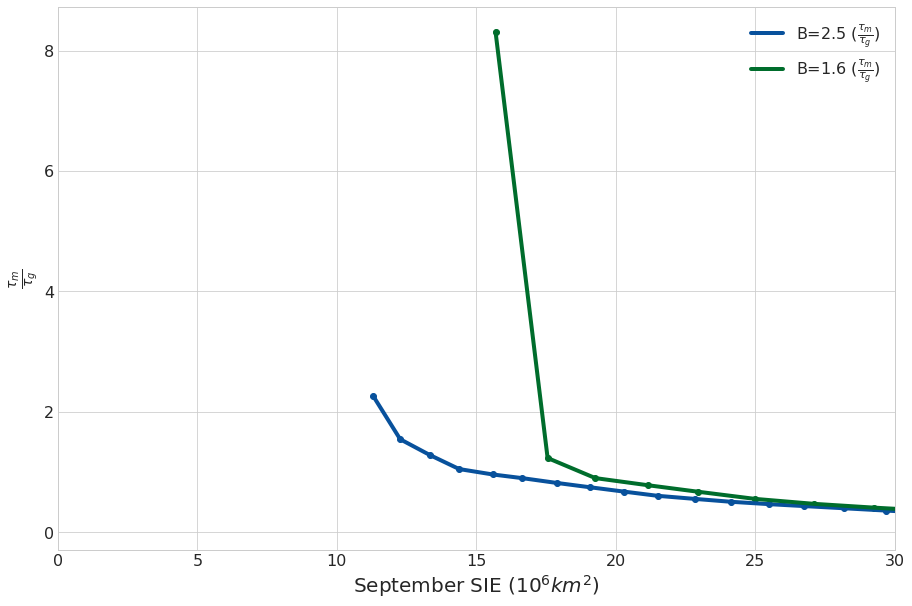

In [11]:
mgr25 = calc_season_length(dfB25)
mgr16 = calc_season_length(dfB16)

B25["summerMean"].sort()
B16["summerMean"].sort()

plt.scatter(np.flip(B25["summerMean"]), mgr25, color=c1[0])
plt.scatter(np.flip(B16["summerMean"]), mgr16, color=c2[0])
plt.plot(np.flip(B25["summerMean"]), mgr25, label=r"B=2.5 ($\frac{\tau_m}{\tau_g}$)", color=c1[0])
plt.plot(np.flip(B16["summerMean"]), mgr16, label=r"B=1.6 ($\frac{\tau_m}{\tau_g}$)", color=c2[0])
plt.xlim(0,30) # plt.ylim(0,2);
plt.xlabel(r"September SIE ($10^6 km^2$)")
plt.ylabel(r"$\frac{\tau_m}{\tau_g}$")
plt.legend()

## Probability Map

# SITV

In [12]:
SIT =  calc_SIT(dfB25.sortby("Forcing"))

/glade/u/apps/ch/opt/python/3.7.12/gnu/9.1.0/pkg-library/20211005/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/glade/u/apps/ch/opt/python/3.7.12/gnu/9.1.0/pkg-library/20211005/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/glade/u/apps/ch/opt/python/3.7.12/gnu/9.1.0/pkg-library/20211005/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be 

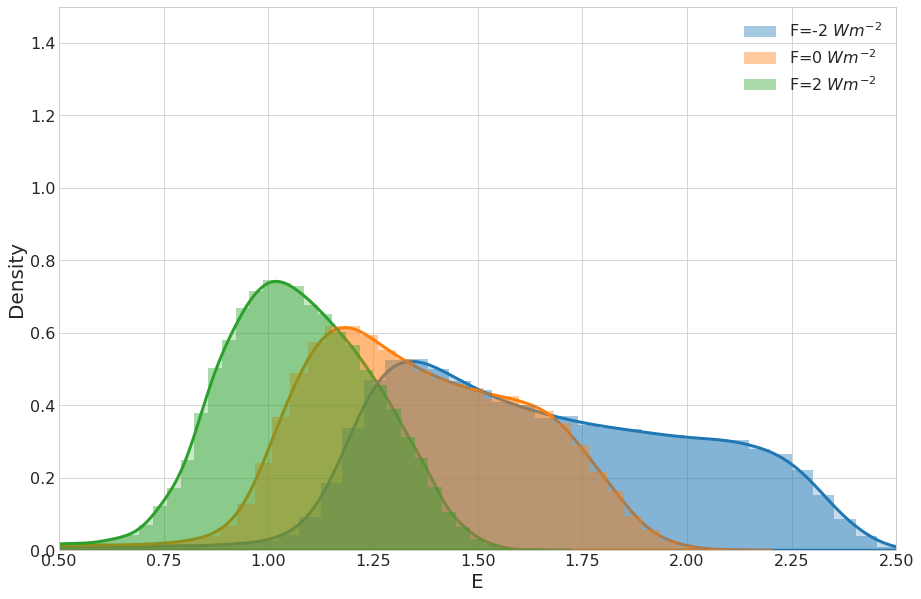

In [13]:
nmon = 8
for f in [-2, 0, 2]:
    sns.distplot(SIT[:,:,spinup:,nmon,:].where(SIT > 0).sel(Forcing=f), hist = True, kde = True, 
            kde_kws = {'shade': True, 'linewidth': 3}, label=f"F={f} " + r"$Wm^{-2}$",)

plt.xlim(.5,2.5)
plt.ylim(0,1.5)
plt.legend()

ValueError: x and y must have same first dimension, but have shapes (32, 400, 12) and (15,)

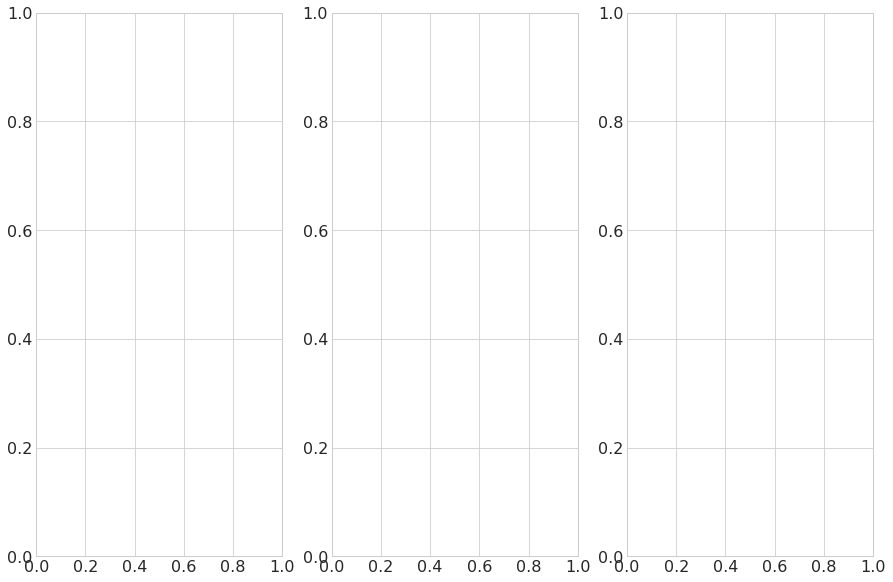

In [14]:
nlat = 385
nmon = 8
forcing = 2.0

fig, (ax1, ax2, ax3) = plt.subplots(1,3)

sitAnom = SIT[:,:,spinup:,:,:].mean(["step"]) - SIT[:,:,spinup:,:,:].mean(["step", "year"])
sitV = sitAnom.std("year")
sitV = sitV.sel(Forcing=forcing)

sitM = SIT[:,:,spinup:,:,:].mean(["step", "year"])
plt.plot(SIT[:,:,spinup:,:,:].mean(["step", "year"]), sitV[nlat:, nmon])


# SITV = SIT[:,nlat:,spinup:,nmon,:].mean(["step"]) - SIT[:,nlat:,spinup:,nmon,:].mean(["step", "year"])).std("year")
# sitvC = SIT[:,nlat:,spinup:,nmon,:].sel(Forcing=forcing).mean(["step"]).std("year")
# sitC = SIT[:,nlat:,spinup:,nmon,:].sel(Forcing=forcing).mean(["step", "year"])

# # Plot of SIT
# m = ax1.pcolormesh(SITV.transpose(), cmap="Reds")
# ax1.set_xlabel(r"$F$ ($Wm^{-2})$")
# ax1.set_ylabel(r"Latitude ($\degree$)")
# ax1.set_title("SIT Interannual Variability")
# ax1.set_xticks(np.arange(0, len(SIT.Forcing), 5))
# ax1.set_xticklabels(SIT.Forcing[::5].values)
# ax1.set_yticklabels(np.around(sitC.x[::5].values, 0))

# # Plot SITV vs. SIT_eq
# ax2.plot(sitC, sitvC, linewidth=6, color="red")
# ax2.set_xlabel(r"$h_{eq} (m)$")
# ax2.set_ylabel(r"$\sigma_{h} (m)$")
# ax2.set_title(f"F={int(forcing)}" + r" ($Wm^{-2}$)", loc="right")

# ax3.plot(sitC.x, sitC, linewidth=6, color="black")
# ax3.set_xlabel(r"Latitude ($\degree$)")
# ax3.set_ylabel(r"$h_{eq} (m)$")
# ax3.set_title(f"F={int(forcing)}" + r" ($Wm^{-2}$)", loc="right")


# m.set_clim(0.05, 0.25)
# cb = plt.colorbar(m, label=r"$\sigma$ in sea-ice thickness (m)", ax=ax1)
# fig.set_size_inches(25, 10)
# fig.tight_layout()
# plt.savefig("SITV_EBM_B25_Fn2.png")

In [ ]:
nlat = 50
nmon = 8
forcing = 2.0

fig, (ax1, ax2, ax3) = plt.subplots(1,3)

sitvC = SIT[:,nlat:,spinup:,nmon,:].sel(Forcing=forcing).mean(["step"]).std("year")
sitC = SIT[:,nlat:,spinup:,nmon,:].sel(Forcing=forcing).mean(["step", "year"])

# Plot of SIT
m = ax1.pcolormesh(SITV.transpose(), cmap="Reds")
ax1.set_xlabel(r"$F$ ($Wm^{-2})$")
ax1.set_ylabel(r"Latitude ($\degree$)")
ax1.set_title("SIT Interannual Variability")
ax1.set_xticks(np.arange(0, len(SIT.Forcing), 5))
ax1.set_xticklabels(SIT.Forcing[::5].values)
ax1.set_yticklabels(np.around(SIT.x[::5].values, 0))

# Plot SITV vs. SIT_eq
ax2.plot(sitC, sitvC, linewidth=6, color="red")
ax2.set_xlabel(r"$h_{eq} (m)$")
ax2.set_ylabel(r"$\sigma_{h} (m)$")
ax2.set_title(f"F={int(forcing)}" + r" ($Wm^{-2}$)", loc="right")

ax3.plot(sitC.x, sitC, linewidth=6, color="black")
ax3.set_xlabel(r"Latitude ($\degree$)")
ax3.set_ylabel(r"$h_{eq} (m)$")
ax3.set_title(f"F={int(forcing)}" + r" ($Wm^{-2}$)", loc="right")


m.set_clim(0.0, 0.02)
cb = plt.colorbar(m, label=r"Variability in sea-ice thickness (m)", ax=ax1)
fig.set_size_inches(25, 10)
fig.tight_layout()
plt.savefig("SITV_EBM_lat_var_F2.png")

# SIEV

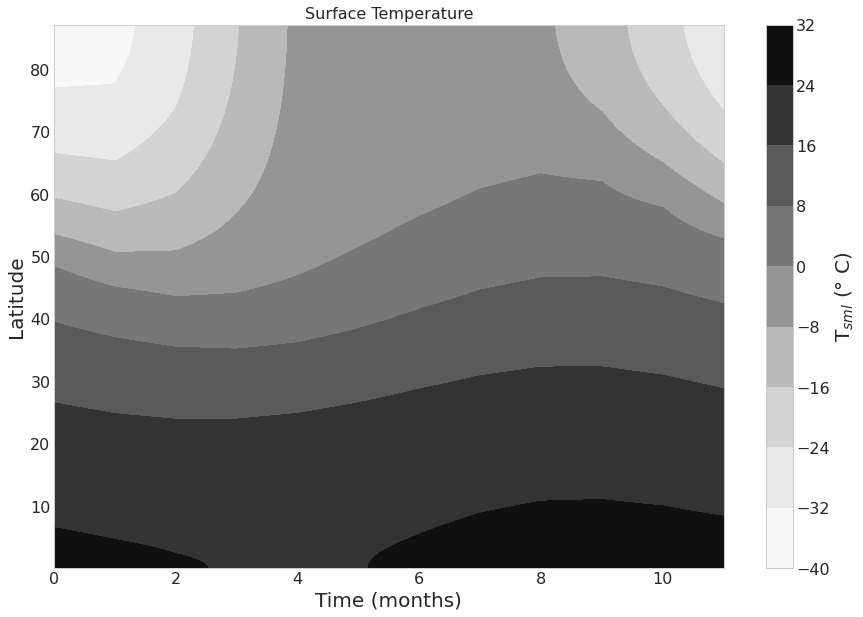

In [4]:
# Sanity Check - Plot Annual Temperature Profile
T = dfB25.T.sel(Forcing="0.0").mean(["year", "step"])
cnt1 = plt.contourf(T.month, T.x, T)
plt.ylabel("Latitude")
plt.title(f"Surface Temperature")
plt.xlabel("Time (months)")
plt.colorbar(cnt1, location="right", label=r"T$_{sml}$ ($\degree$ C)")

### Process Temperature Data

In [5]:
# --------------- Calculate Global September Surface Temperature Mean and Variance -----------------
monIdx = 8
spinup = 100

darea = area_grid(lat=dfB25.x.values)
total_area = darea.sum(["x"])

monB25 = dfB25.T[:,:,spinup:,monIdx,:].mean(["step"])
T25_weighted = (monB25*darea/total_area).T.sum(["x"])
T25_global = T25_weighted.T.mean(["year"])
T25_global_var = T25_weighted.T.var(["year"])

monB16 = dfB16.T[:,:,spinup:,monIdx,:].mean(["step"])
T16_weighted = (monB16*darea/total_area).T.sum(["x"])
T16_global = T16_weighted.T.mean(["year"])
T16_global_var = T16_weighted.T.var(["year"])

# --------------------- Calculate Temp time-series -----------------
def temp_timeseries(df, lat, monIdx):
    darea = area_grid(lat=df.x.values)
    total_area = darea.x.sel(x=slice(lat, 90)).sum(["x"])
    mon = df.T.sel(x=slice(lat, 90))
    mon = mon[:,:,spinup:,monIdx,:].mean(["step"])
    Ts = (mon*darea.x.sel(x=slice(lat, 90))/total_area).T.sum(["x"])
    return Ts

# Arctic Temperature Time series
LAT = 70
TsD5P = temp_timeseries(dfB16, LAT, monIdx)
TsD4P = temp_timeseries(dfB16D4, LAT, monIdx)
TsD8P = temp_timeseries(dfB16D8, LAT, monIdx)
Ts25D5P = temp_timeseries(dfB25, LAT, monIdx)


# Global Temperature Time series
LAT = 0
TsD5G = temp_timeseries(dfB16, LAT, monIdx)
TsD4G = temp_timeseries(dfB16D4, LAT, monIdx)
TsD8G = temp_timeseries(dfB16D8, LAT, monIdx)
Ts25D5G = temp_timeseries(dfB25, LAT, monIdx)


# --------------------- Calculate SIA -----------------------------
def calc_SIA(df):
    """
    Calculate sea ice area given DataFrame with enthalpy (E)
    """
    nens, nx, nyear, nmon, nstep = df.E.shape
    # Create iceEdge array: default to iceEdge at 90N (i.e. no ice)
    iceEdge = np.full((nens, nyear, nmon, nstep), 90) 
    # Get lat for each location with df.E<0. Issue is if df.E>0 is always true (i.e. no ice) np.argmax assumes ice edge is at equator
    iceEdgeMask = (df.x.values[np.argmax(df.E.values<0, axis=1).flatten()]).reshape(nens, nyear, nmon, nstep)

    iceEdge = np.where(np.argmax(df.E.values<0, axis=1), iceEdgeMask, iceEdge)
    iceArea = 2*np.pi*(R/1e3)**2*(1 - np.sin(np.deg2rad(iceEdge)))/1e6 #ice area in million km^2
    iceArea = np.mean(iceArea, axis=3)
    return iceArea   

# siceB16D4 = calc_SIA(dfB16D4)
# save("siceB16D4.pkl", siceB16D4); print("Finished B16D4")

# siceB16D8 = calc_SIA( dfB16D8)
# save("siceB16D8.pkl", siceB16D8); print("Finished B16D8")

# siceB16D5 = calc_SIA(dfB16)
# save("siceB16D5.pkl", siceB16D5); print("Finished B16D5")

# siceB25D5 = calc_SIA(dfB25)
# save("siceB25D5.pkl", siceB25D5); print("Finished B26D5")

siceB16D4 = load("siceB16D4.pkl")
siceB16D8 = load("siceB16D8.pkl")
siceB16D5 = load("siceB16D5.pkl")
siceB25D5 = load("siceB25D5.pkl")


## Verify Magnitude of BRM

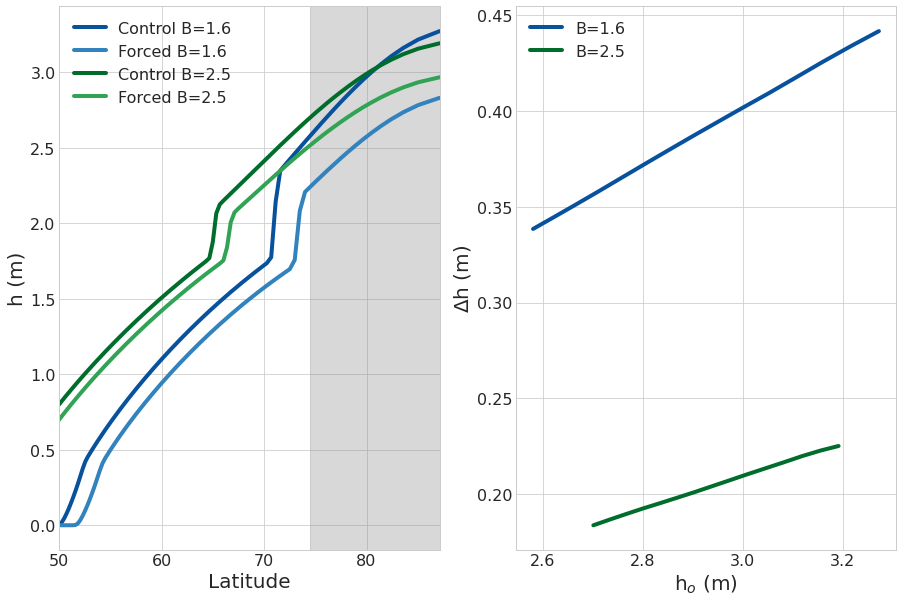

In [6]:
# ------------------ Calculate SIT -----------------------------
monIdx = 3

fig, (ax1, ax2) = plt.subplots(1,2)
c1 = ["#08519c", "#006d2c"]
c2 = ["#3182bd", "#31a354"]

dfs = {
    "B=1.6": dfB16, 
    "B=2.5": dfB25, 
}


for i, (label, df) in enumerate(dfs.items()):
    sit = calc_SIT(df)[:,:,spinup:,monIdx,:]
    if label == "B=1.6": 
        Fc = -5.0; Ff = -4.0
    else: 
        Fc = -2.0; Ff = -1.0

    sitC = sit.sel(Forcing=Fc).mean(["step", "year"])
    sitF = sit.sel(Forcing=Ff).mean(["step", "year"])

    sitC_shaded = sitC.sel(x=slice(74.5,90))
    sitF_shaded = sitF.sel(x=slice(74.5,90))
    dsit = sitC_shaded - sitF_shaded

    ax1.plot(df.x, sitC, label=f"Control {label}", color=c1[i])
    ax1.plot(df.x, sitF, label=f"Forced {label}", color=c2[i])
    ax2.plot(sitC_shaded, dsit, label=label, color=c1[i])
    # a, b = np.polyfit(sitC_shaded, dsit, 1)
    # ax2.plot(sitC_shaded, a*sitC_shaded + b)

ax1.axvspan(74.5, np.max(dfs["B=1.6"].x.values), alpha=0.3, color='gray')   
ax1.set_xlabel("Latitude")
ax2.set_xlabel(r"h$_o$ (m)")
ax1.set_ylabel("h (m)")
ax2.set_ylabel(r"$\Delta$h (m)")
ax1.set_xlim(50, np.max(dfs["B=1.6"].x.values))
ax1.legend()
ax2.legend()
# ax2.set_xlim(
# ax2.set_xlim(65, 90)

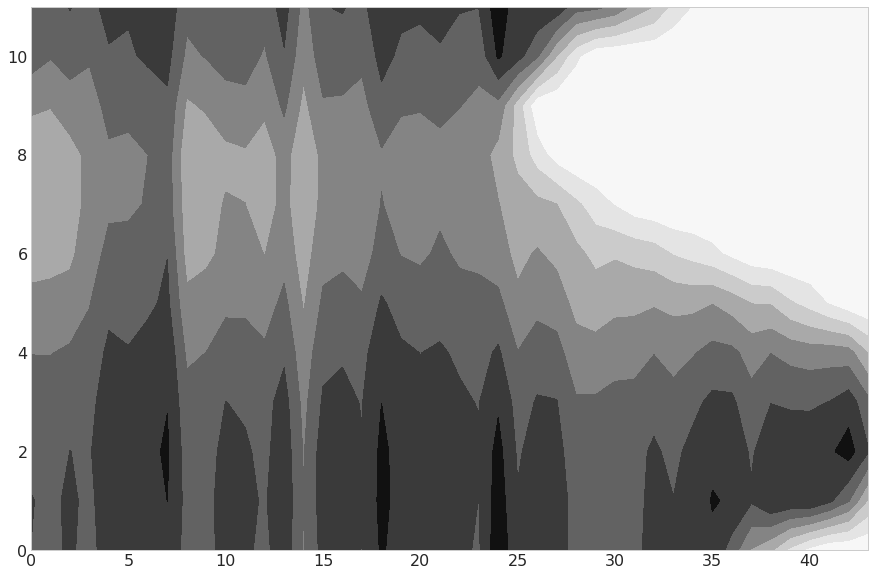

Task was destroyed but it is pending!
task: <Task pending coro=<Kernel.poll_control_queue() running at /glade/u/apps/ch/opt/python/3.7.12/gnu/9.1.0/pkg-library/20211005/lib/python3.7/site-packages/ipykernel/kernelbase.py:227> wait_for=<Future finished result=[<zmq.sugar.fr...x2b2877cf6c50>, <zmq.sugar.fr...x2b2877cf6650>, <zmq.sugar.fr...x2b2877cf6f50>, <zmq.sugar.fr...x2b2877cf6a10>, <zmq.sugar.fr...x2b2877cf6d10>, <zmq.sugar.fr...x2b2877cf6dd0>, ...]> cb=[_chain_future.<locals>._call_set_state() at /glade/u/apps/ch/opt/python/3.7.12/gnu/9.1.0/lib/python3.7/asyncio/futures.py:358]>


In [36]:
spinup = 100
mon = 2
    
# colors = ["#d7191c", "#fdae61", "#abd9e9", "#2c7bb6"]
colors = ["crimson", "navy"]

sices = {
    # "B=1.6, D=.4": siceB16D4, 
    # "B=1.6, D=.8": siceB16D8, 
    # "B=1.6, D=.5": siceB16D5, 
    # "B=2.5, D=.5": siceB25D5,
    "B=1.6": siceB16D5, 
    # "B=2.5": siceB25D5,
}

def plot_trend():
    for i, (label, sice) in enumerate(sices.items()):
        sice_mean = np.mean(sice[:,spinup:,mon], axis=1)
        sice_var = np.std(sice[:,spinup:,mon], axis=1)
        mean, var = zip(*sorted(zip(sice_mean,sice_var)))
        plt.scatter(sice_mean, sice_var, label=label, color=colors[i])
        plt.plot(mvavg(mean, w=3), mvavg(var, w=3), color=colors[i])


    plt.xlabel(r"$\mu$ summer sea ice area (10$^6$km$^2$)", fontweight="bold")
    plt.ylabel(r"$\sigma$ summer sea ice area (10$^6$km$^2$)", fontweight="bold")
    plt.title("Variability of summer sea ice area in an EBM", fontweight="bold", fontsize=24)
    plt.legend()
    # plt.xlim(0, 35)
    plt.savefig("/glade/work/zespinosa/Projects/sia_ecs/ebm_var.png")

def plot_cycle(): 
    for i, (label, sice) in enumerate(sices.items()):
        sice_mean = np.mean(sice[:,spinup:,:], axis=1)
        sice_var = np.std(sice[:,spinup:,:], axis=1)
        # print(sice_var.shape)
        plt.contourf(np.arange(0,44), np.arange(0,12), sice_var.T)
        # plt.contourf(np.arange(0,4 4), np.arange(0,12), sice_mean.T)
        
#         mean, var = zip(*sorted(zip(sice_mean,sice_var)))
#         plt.scatter(sice_mean, sice_var, label=label, color=colors[i])
#         plt.plot(mvavg(mean, w=3), mvavg(var, w=3), color=colors[i])


#     plt.xlabel(r"$\mu$ summer sea ice area (10$^6$km$^2$)", fontweight="bold")
#     plt.ylabel(r"$\sigma$ summer sea ice area (10$^6$km$^2$)", fontweight="bold")
#     plt.title("Variability of summer sea ice area in an EBM", fontweight="bold", fontsize=24)
#     plt.legend()
#     # plt.xlim(0, 35)
#     plt.savefig("/glade/work/zespinosa/Projects/sia_ecs/ebm_var.png")
plot_cycle()
# dfB16
# plot_trend()

In [15]:
from scipy.stats import stats

spinup = 100
mon = 8
    
colors = ["#d7191c", "#fdae61", "#abd9e9", "#2c7bb6"]
TsG = [TsD4G, TsD8G, TsD5G, Ts25D5G]
TsP = [TsD4P, TsD8P, TsD5P, Ts25D5P]

sices = {
    "B=1.6, D=.4": siceB16D4, 
    "B=1.6, D=.8": siceB16D8, 
    "B=1.6, D=.5": siceB16D5, 
    "B=2.5, D=.5": siceB25D5, 
}

fig, (axG, axP) = plt.subplots(1,2)
for i, (label, sice) in enumerate(sices.items()):
    sice_var = np.var(sice[:,spinup:,mon], axis=1)
    TsG_var = np.var(TsG[i], axis=0)
    TsP_var = np.var(TsP[i], axis=0)
    rG, _ = stats.pearsonr(TsG_var, sice_var)
    rP, _ = stats.pearsonr(TsP_var, sice_var)
    axG.scatter(TsG_var, sice_var, label=f"{label} r$^2$={np.around(rG**2,1)}", color=colors[i])
    axP.scatter(TsP_var, sice_var, label=f"{label} r$^2$={np.around(rP**2,1)}", color=colors[i])
    print(f"Finished plotting {label}")

axG.set_xlabel(r"$\sigma^2$ September Global T$_{sml}$ (10$^6$km$^2$)")
axP.set_xlabel(r"$\sigma^2$ September Polar T$_{sml}$ (10$^6$km$^2$)")
axG.set_ylabel(r"$\sigma^2$ September SIE (10$^6$km$^2$)")
axP.set_ylabel(r"$\sigma^2$ September SIE (10$^6$km$^2$)")
axP.legend()
axG.legend()

NameError: name 'TsD4G' is not defined

## Diffusion Influence on Sea Ice Extent Variability

KeyboardInterrupt: 

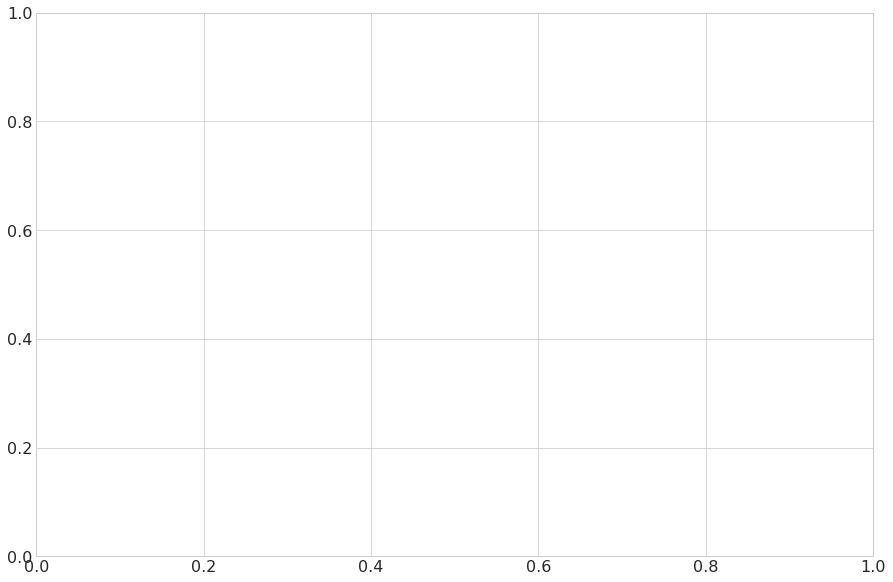

In [107]:
monIdx = 8
"#9ecae1","#6baed6", "#3182bd","#08519c"
# print(siceB16D4[:,:,monIdx].mean("year").values)
# plt.scatter(siceB16D4[:,:,monIdx].mean("year"), siceB16D4[:,:,monIdx].var("year"), label="B=1.6, D=.4", color="#9ecae1")
plt.scatter(siceB16D5[:,:,monIdx].mean("year"), siceB16D5[:,:,monIdx].var("year"), label="B=1.6, D=.5", color="#6baed6")
# plt.scatter(siceB16D8[:,:,monIdx].mean("year"), siceB16D8[:,:,monIdx].var("year"), label="B=1.6, D=.8", color="#3182bd")
# plt.scatter(siceB25D5[:,:,monIdx].mean("year"), siceB25D5[:,:,monIdx].var("year"), label="B=2.5, D=.5", color="#08519c")

## Correlation between Arctic and Global September Temperature

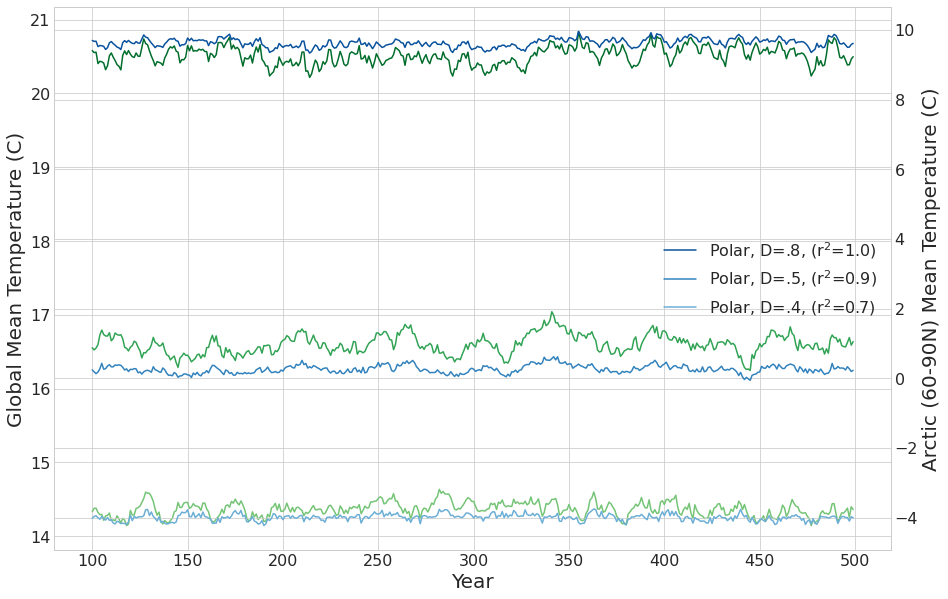

In [85]:
from scipy.stats import stats

r5, p = stats.pearsonr(TsD5P.T.sel(Forcing=0.0), TsD5G.T.sel(Forcing=0.0))
r4, p = stats.pearsonr(TsD4P.T.sel(Forcing=0.0), TsD4G.T.sel(Forcing=0.0))
r8, p = stats.pearsonr(TsD8P.T.sel(Forcing=0.0), TsD8G.T.sel(Forcing=0.0))

fig, axG = plt.subplots()
axP = axG.twinx()

# Plot Arctic Temperature Time Series
axP.plot(TsD8P.year, TsD8P.T.sel(Forcing=0.0), label=f"Polar, D=.8, (r$^2$={np.around(r8**2,1)})", color="#08519c")
axP.plot(TsD5P.year, TsD5P.T.sel(Forcing=0.0), label=f"Polar, D=.5, (r$^2$={np.around(r5**2,1)})", color="#3182bd")
axP.plot(TsD4P.year, TsD4P.T.sel(Forcing=0.0), label=f"Polar, D=.4, (r$^2$={np.around(r4**2,1)})", color="#6baed6")
axP.set_ylabel("Arctic (60-90N) Mean Temperature (C)")

# Plot Global Temperature Time Series
axG.set_ylabel("Global Mean Temperature (C)")
axG.plot(TsD8G.year, TsD8G.T.sel(Forcing=0.0), label=f"D=.8, r$^2$={np.around(r8**2,1)}", color="#006d2c")
axG.plot(TsD5G.year, TsD5G.T.sel(Forcing=0.0), label=f"D=.5, r$^2$={np.around(r5**2,1)}", color="#31a354")
axG.plot(TsD4G.year, TsD4G.T.sel(Forcing=0.0), label=f"D=.4, r$^2$={np.around(r4**2,1)}", color="#74c476")
axG.set_xlabel("Year")
plt.legend()

# c1 = ["#9ecae1","#6baed6", "#3182bd","#08519c"]
# c2 = ["#a1d99b","#74c476","#31a354", "#006d2c"]
# plt.ylim(0, 1)

In [6]:
# Variability of September Surface Temperature by latitude
monB25 = dfB25.T[:,:,spinup:,monIdx,:].mean(["step"])
T25_lat_var = monB25.T.var(["year"])

monB16 = dfB16.T[:,:,spinup:,monIdx,:].mean(["step"])
T16_lat_var = monB16.T.var(["year"])

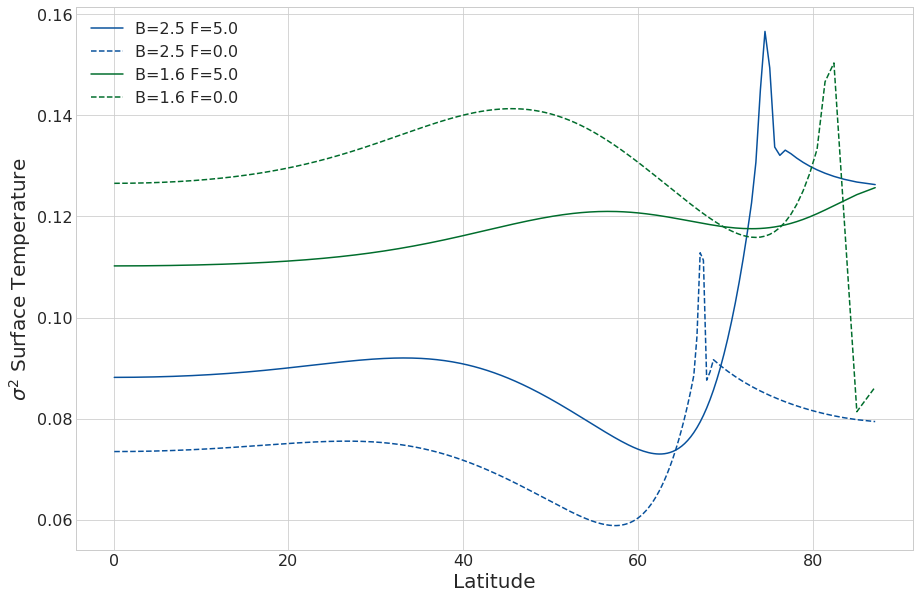

In [85]:
c1 = ["#9ecae1","#6baed6", "#3182bd","#08519c"]
c2 = ["#a1d99b","#74c476","#31a354", "#006d2c"]
c1.reverse()
c2.reverse()

plt.plot(T25_lat_var.x, np.sqrt(T25_lat_var.T.sel(Forcing="5.0")), label=f"B=2.5 F=5.0", color=c1[0])
plt.plot(T25_lat_var.x, np.sqrt(T25_lat_var.T.sel(Forcing="0.0")), label=f"B=2.5 F=0.0", color=c1[0], linestyle="dashed")

plt.plot(T16_lat_var.x, np.sqrt(T16_lat_var.T.sel(Forcing="5.0")), label=f"B=1.6 F=5.0", color=c2[0])
plt.plot(T16_lat_var.x, np.sqrt(T16_lat_var.T.sel(Forcing="0.0")), label=f"B=1.6 F=0.0", color=c2[0], linestyle="dashed")

plt.xlabel("Latitude")
plt.ylabel(r"$\sigma^2 $ Surface Temperature")
plt.legend()

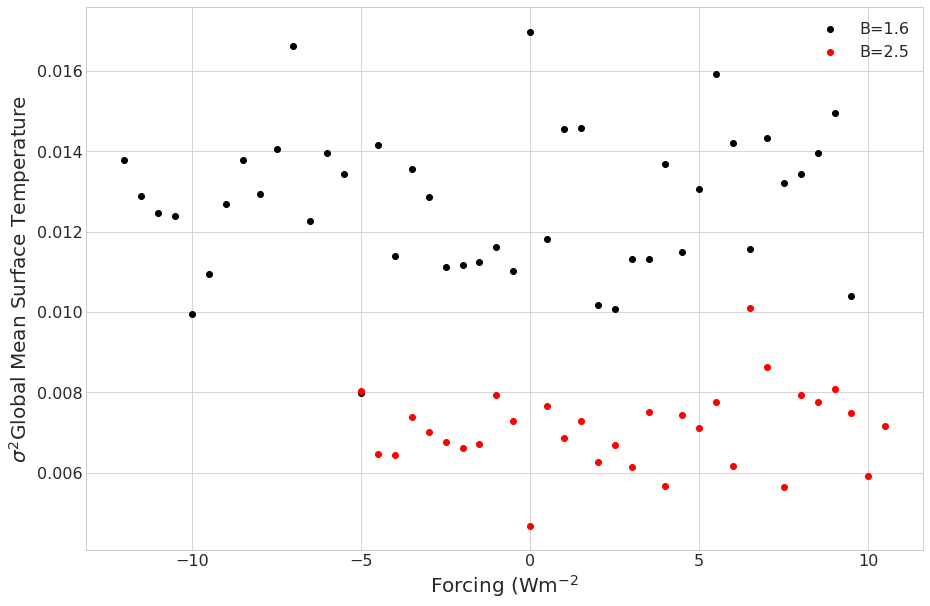

In [86]:
plt.scatter([float(f) for f in dfB16.Forcing.values], T16_global_var, label="B=1.6", color="black")
plt.scatter([float(f) for f in dfB25.Forcing.values], T25_global_var, label="B=2.5", color="red")
plt.ylabel(r"$\sigma^2 $Global Mean Surface Temperature"); plt.xlabel(r"Forcing (Wm$^{-2}$")
plt.legend()

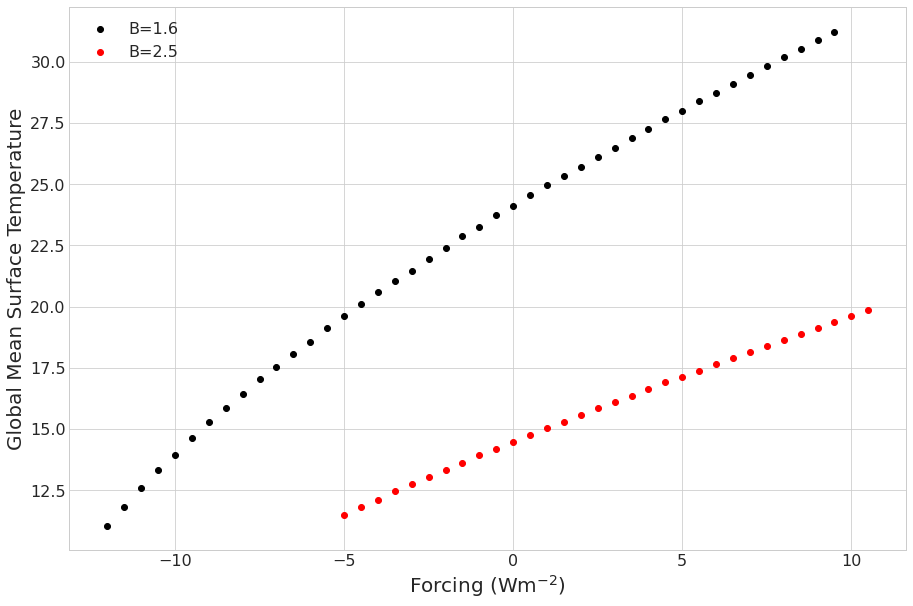

In [7]:
plt.scatter([float(f) for f in dfB16.Forcing.values], T16_global, label="B=1.6", color="black")
plt.scatter([float(f) for f in dfB25.Forcing.values], T25_global, label="B=2.5", color="red")
plt.ylabel(r"Global Mean Surface Temperature"); plt.xlabel(r"Forcing (Wm$^{-2}$)")
plt.legend()

In [87]:
Tmu16, Tvar16 = zip(*sorted(zip(T16_global,T16_global_var)))
Tmu25, Tvar25 = zip(*sorted(zip(T25_global,T25_global_var)))

(4.0, 12.5)

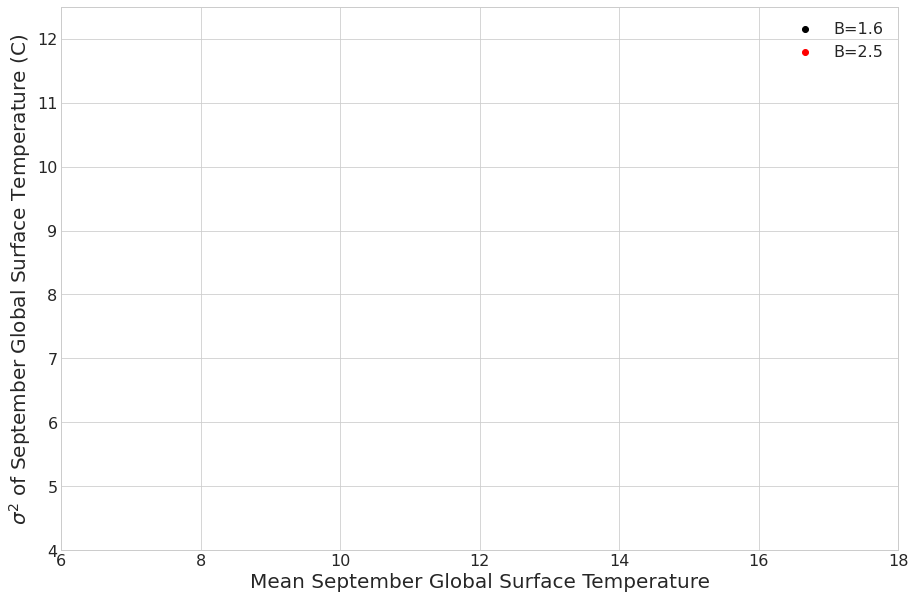

In [88]:
plt.scatter(T16_global.T.values, T16_global_var.T.values, label="B=1.6", color="black")
plt.scatter(T25_global.T.values, T25_global_var.T.values, label="B=2.5", color="red")
plt.legend()
plt.ylabel("$\sigma^2$ of September Global Surface Temperature (C)"); plt.xlabel(r"Mean September Global Surface Temperature")
plt.xlim(6,18); plt.ylim(4,12.5)

### Process Sea-Ice Data
Calculate global mean sea-ice thickness

In [8]:
Lf = 9.5

SITB25 = (-dfB25.E/Lf*(dfB25.E<0))
SITB16 = (-dfB16.E/Lf*(dfB16.E<0))

SITB25mon = SITB25[:,:,spinup:,monIdx,:].mean(["step"])
SITB25mon = (SITB25mon*darea/total_area).sum(["x"])
SITB25mean = SITB25mon.mean(["year"])

SITB16mon = SITB16[:,:,spinup:,monIdx,:].mean(["step"])
SITB16mon = (SITB16mon*darea/total_area).sum(["x"])
SITB16mean = SITB16mon.mean(["year"])

(0.0, 35.0)

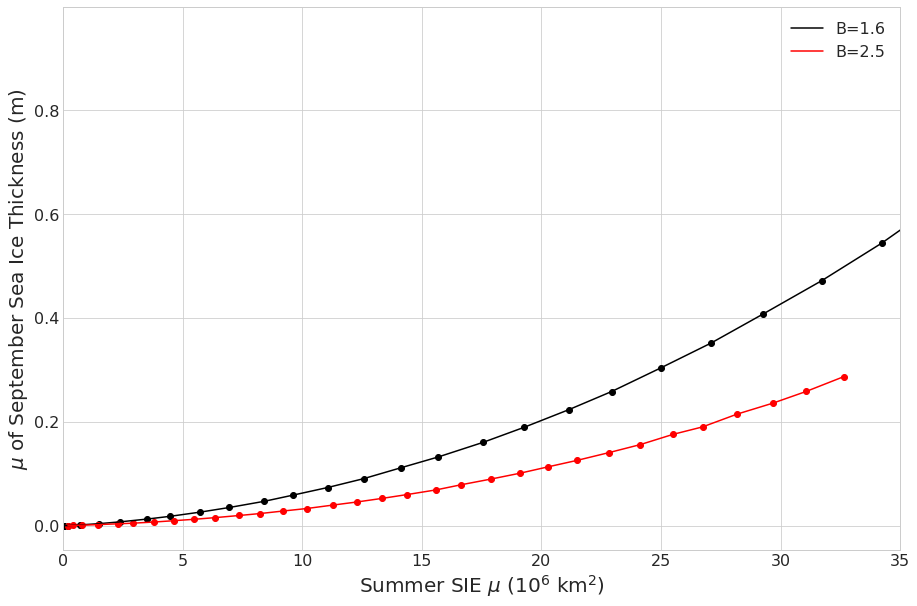

In [90]:
mu16, sit16 = zip(*sorted(zip(B16["summerMean"], SITB16mean.values)))
mu25, sit25 = zip(*sorted(zip(B25["summerMean"], SITB25mean.values)))

plt.scatter(mu16, sit16, color="black")
plt.scatter(mu25, sit25, color="red")
plt.plot(mu16, sit16, label="B=1.6", color="black")
plt.plot(mu25, sit25, label="B=2.5", color="red")
plt.legend()
plt.ylabel("$\mu$ of September Sea Ice Thickness (m)"); plt.xlabel(r"Summer SIE $\mu$ (10$^6$ km$^2$)")
plt.xlim(0,35)

(4.0, 12.5)

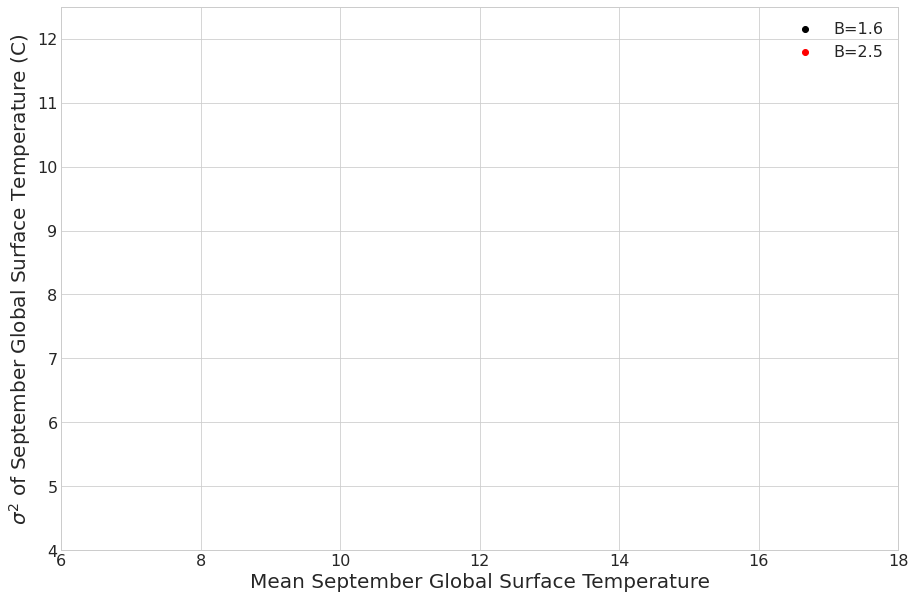

In [91]:
plt.scatter(T16_global.T.values, T16_global_var.T.values, label="B=1.6", color="black")
plt.scatter(T25_global.T.values, T25_global_var.T.values, label="B=2.5", color="red")
plt.legend()
plt.ylabel("$\sigma^2$ of September Global Surface Temperature (C)"); plt.xlabel(r"Mean September Global Surface Temperature")
plt.xlim(6,18); plt.ylim(4,12.5)

No handles with labels found to put in legend.


Text(0.5, 0, '$\\sigma^2$ Summer Temperature (C)')

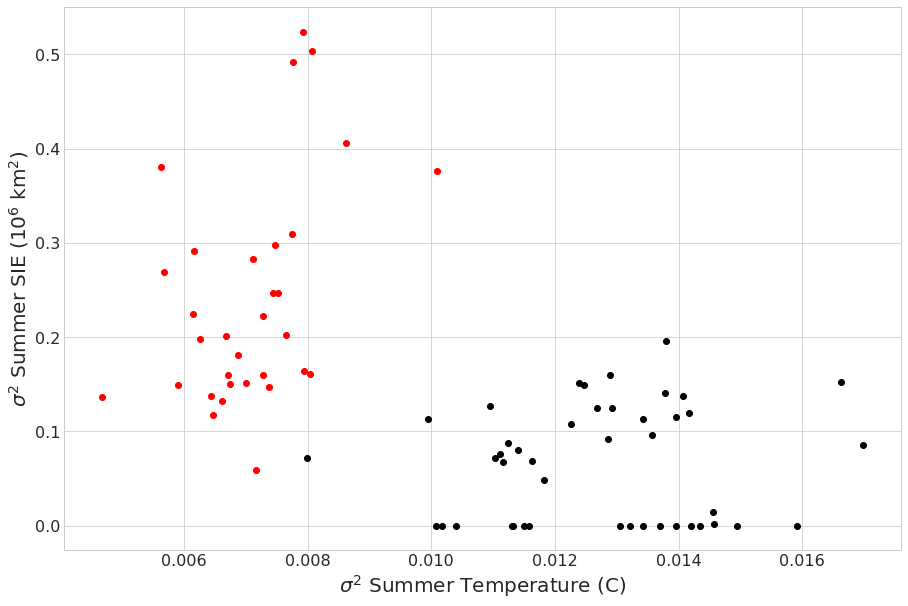

In [13]:
mu16, var16 = zip(*sorted(zip(B16["summerMean"], B16["summerVar"])))
mu25, var25 = zip(*sorted(zip(B25["summerMean"], B25["summerVar"])))

F25 = [float(f) for f in dfB25.Forcing.values]
F16 = [float(f) for f in dfB16.Forcing.values]
_, Tvar16 = zip(*sorted(zip(F16, T16_global_var.T.values,)))
_, Tvar25 = zip(*sorted(zip(F25, T25_global_var.T.values,)))
Tvar16 = list(Tvar16)
Tvar25 = list(Tvar25)
Tvar16.reverse()
Tvar25.reverse()

plt.scatter(Tvar16, var16, color="black")
plt.scatter(Tvar25, var25, color="red")
# plt.plot(Tvar16, var16, label="B=1.6", color="black")
# plt.plot(Tvar25, var25, label="B=2.5", color="red")
plt.legend()
plt.ylabel(r"$\sigma^2$ Summer SIE (10$^6$ km$^2$)"); plt.xlabel(r"$\sigma^2$ Summer Temperature (C)")
# plt.xlim(3,12.5)

Text(0.5, 0, 'Summer SIE $\\mu$ (10$^6$ km$^2$)')

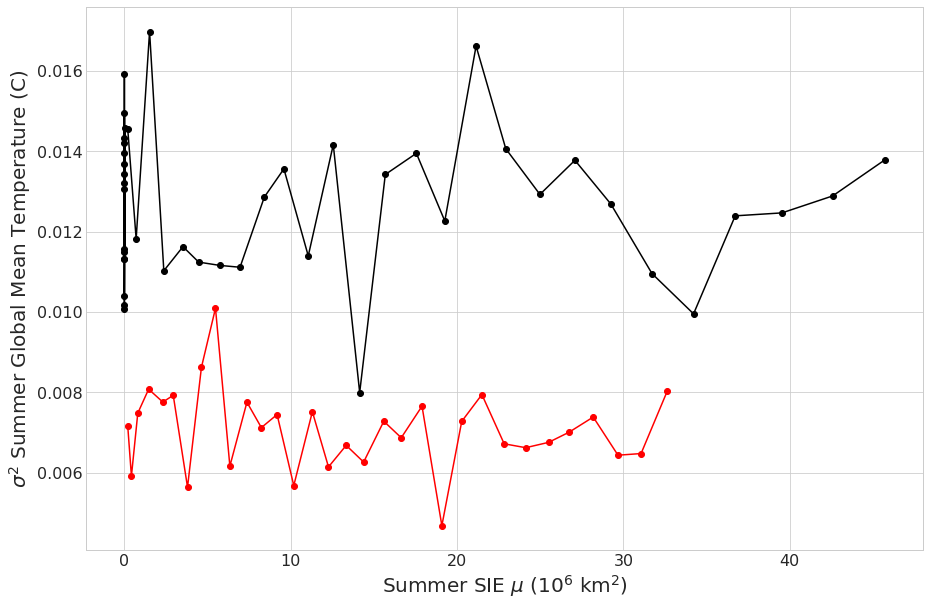

In [12]:
plt.scatter(mu16, Tvar16, color="black")
plt.scatter(mu25, Tvar25, color="red")
plt.plot(mu16, Tvar16, label="B=1.6", color="black")
plt.plot(mu25, Tvar25, label="B=2.5", color="red")
plt.ylabel("$\sigma^2$ Summer Global Mean Temperature (C)"); plt.xlabel(r"Summer SIE $\mu$ (10$^6$ km$^2$)")
# plt.legend(); plt.xlim(0, 35); plt.ylim(0,12.5)

In [ ]:
mu16, T16 = zip(*sorted(zip(B16["summerMean"], T16_global.T.values)))
mu25, T25 = zip(*sorted(zip(B25["summerMean"], T25_global.T.values)))

plt.scatter(mu16, T16, color="black")
plt.scatter(mu25, T25, color="red")
plt.plot(mu16, T16, label="B=1.6", color="black")
plt.plot(mu25, T25, label="B=2.5", color="red")
plt.legend()
plt.ylabel("Mean September Global Surface Temperature"); plt.xlabel(r"Summer SIE $\mu$ (10$^6$ km$^2$)")
# plt.xlim(0,35)

In [ ]:
mu16 = list(mu16)
mu25 = list(mu25)

mu16.reverse()
mu25.reverse()

In [ ]:
plt.scatter(B16["summerMean"], B16["summerVar"])
plt.scatter(B25["summerMean"], B25["summerVar"])
mu16, var16 = zip(*sorted(zip(B16["summerMean"], B16["summerVar"])))
mu25, var25 = zip(*sorted(zip(B25["summerMean"], B25["summerVar"])))
plt.plot(mu16, mvavg(var16), label="B=1.6")
plt.plot(mu25, mvavg(var25), label="B=2.5")
plt.ylabel("$\sigma^2$ (10$^6$ km$^2$)"); plt.xlabel(r"$\mu$ (10$^6$ km$^2$)")
plt.xlim(0,30); plt.legend()

In [ ]:
plt.scatter(B16["summerMean"], B16["summerSkew"], color="black")
plt.scatter(B25["summerMean"], B25["summerSkew"], color="red")
nensm = [15,19,23,27,31]
# for n in nensm: plt.scatter(B25["summerMean"][n], B25["summerSkew"][n], label=np.around(B25["summerMean"][n]))
mu16, skew16 = zip(*sorted(zip(B16["summerMean"], B16["summerSkew"])))
mu25, skew25 = zip(*sorted(zip(B25["summerMean"], B25["summerSkew"])))
plt.plot(mu16, mvavg(skew16), label="B1.6", color="black")
plt.plot(mu25, mvavg(skew25), label="B2.5", color="red")
plt.ylabel(r"$\nu$ (10$^6$ km$^2$)"); plt.xlabel(r"$\mu$ (10$^6$ km$^2$)")
plt.ylim(-1.5,3.0); plt.legend()

In [ ]:
spinup = 100
df25 = [np.average(B25["raw_data"][nens,spinup:,8,:], axis=1) for nens in nensm]
for i,n in enumerate(nensm):
    mu, nu = np.around(B25["summerMean"][n],2), np.around(B25["summerSkew"][n],2)
    median, mode = np.around(np.median(df25[i]),1), np.around(scipy.stats.mode(df25[i])[0][0], 1)
    sns.distplot(df25[i], hist = True, kde = True, 
                 kde_kws = {'shade': True, 'linewidth': 3}, 
                 label=f"skew={nu} mu={mu} median={median}, mode={mode}")
plt.legend()
plt.ylim(0,3)